# InsCure Capstone Project 

### Import library yang akan digunakan

In [2]:
# Import Library
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import joblib
import shutil
import random
import string
import cv2
import tempfile
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Mengeload dataset dan membagi menjadi 500 gambar per kelas

In [4]:
# Initiate Directory
dataset_dir = '\Kuliah\Bangkit\Capstone\Dataset_Original'
output_dir = '\Kuliah\Bangkit\Capstone\Dataset_500'

# Image per class
num_images_per_class = 500

# Make sure there is an output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List of class
classes = os.listdir(dataset_dir)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        # Pilih acak 500 gambar dari kelas ini
        selected_images = random.sample(images, num_images_per_class)
        
        # Buat direktori baru untuk kelas ini di direktori tujuan
        new_class_dir = os.path.join(output_dir, cls)
        os.makedirs(new_class_dir, exist_ok=True)
        
        for img in selected_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(new_class_dir, img)
            shutil.copy(src, dst)
            
print("Dataset has been successfully partitioned.")


Dataset has been successfully partitioned.


### Mengesplit data yang telah dipartisi menjadi training set dan validation set

In [3]:
# Defining the directory
dataset_directory = '\Kuliah\Bangkit\Capstone\Dataset_500'

# Setting parameters
batch_size = 64
img_height = 224
img_width = 224
validation_split = 0.2
image_shape = (img_height, img_width, 3)

# Creating the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Creating the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Printing class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.
Found 5000 files belonging to 10 classes.
Using 1000 files for validation.
Class names: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


### Visualisasi Sampel Gambar


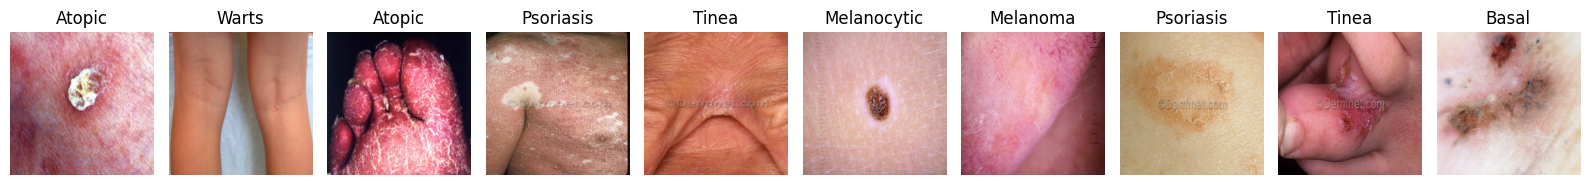

In [10]:
# Plotting a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      label = class_names[int(labels[k])]
      simplified_label = label.split()[0]  
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(simplified_label)
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

### Membuat Training Directory dan Validation Directory


In [13]:
# Define the directory for training and validation 
train_dir = 'train_dataset'
validation_dir = 'validation_dataset'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Function to copy image from dataset to directory
def copy_images(dataset, directory):
    for images, labels in dataset:
        for i in range(len(images)):
            class_name = class_names[labels[i]]
            class_dir = os.path.join(directory, class_name)
            os.makedirs(class_dir, exist_ok=True)
            img_path = os.path.join(class_dir, f'image_{len(os.listdir(class_dir))}.jpg')
            img = tf.keras.preprocessing.image.array_to_img(images[i])
            img.save(img_path)

# Copy the image to training directory 
copy_images(train_dataset, train_dir)

# Copy the image to validation directory 
copy_images(validation_dataset, validation_dir)

print(f"Datasets saved to directories: {train_dir} and {validation_dir}")

Datasets saved to directories: train_dataset and validation_dataset


### Membuat Generator untuk CNN dan Data Augmentation

In [8]:
# Augmentation configuration for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=validation_split
)

# Only rescaling for the validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Creating the training dataset
train_generator = train_datagen.flow_from_directory(
    dataset_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

# Creating the validation dataset
validation_generator = validation_datagen.flow_from_directory(
    dataset_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

# Printing class names
class_names = list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Class: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


### Melihat distribusi kelas untuk Training dan Validation dataset

Distribusi kelas di set pelatihan: Counter({2: 418, 0: 411, 1: 410, 5: 401, 4: 398, 8: 397, 7: 397, 6: 395, 9: 388, 3: 385})


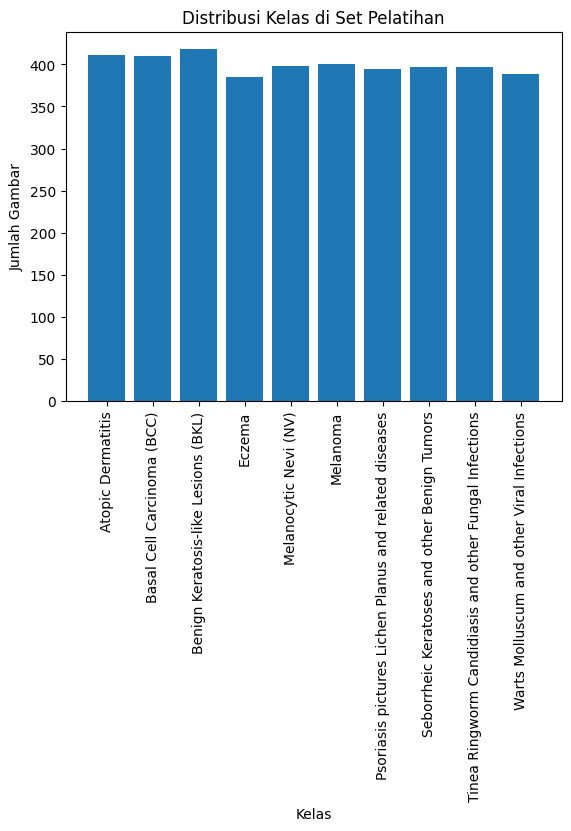

In [9]:
import collections

# Class distribution in training dataset
class_count = collections.Counter()
for images, labels in train_dataset:
    class_count.update(labels.numpy())

print("Distribusi kelas di set pelatihan:", class_count)

# Visualization
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.title('Distribusi Kelas di Set Pelatihan')
plt.show()

Distribusi kelas di set validasi: Counter({3: 115, 9: 112, 6: 105, 8: 103, 7: 103, 4: 102, 5: 99, 1: 90, 0: 89, 2: 82})


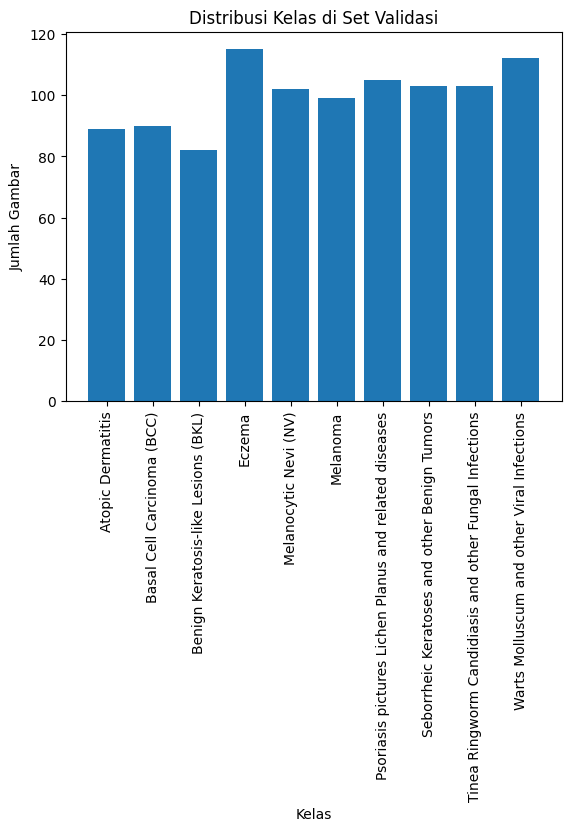

In [7]:
# Class distribution in validation dataset
class_count = collections.Counter()
for images, labels in validation_dataset:
    class_count.update(labels.numpy())

print("Distribusi kelas di set validasi:", class_count)

# Visualization
plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=90)
plt.title('Distribusi Kelas di Set Validasi')
plt.show()

### Membuat model dengan memanfaatkan MobileNetv2

In [11]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Mengasumsikan Anda memiliki 10 kelas
])

optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=70  # Sesuaikan jumlah epoch sesuai kebutuhan Anda
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

Epoch 1/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 975ms/step - accuracy: 0.2034 - loss: 2.2847 - val_accuracy: 0.3430 - val_loss: 1.7801
Epoch 2/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 952ms/step - accuracy: 0.2950 - loss: 1.8093 - val_accuracy: 0.3790 - val_loss: 1.6449
Epoch 3/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 948ms/step - accuracy: 0.3420 - loss: 1.7101 - val_accuracy: 0.3990 - val_loss: 1.5800
Epoch 4/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 864ms/step - accuracy: 0.3566 - loss: 1.6372 - val_accuracy: 0.4330 - val_loss: 1.5211
Epoch 5/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 863ms/step - accuracy: 0.3849 - loss: 1.5946 - val_accuracy: 0.4210 - val_loss: 1.4993
Epoch 6/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 879ms/step - accuracy: 0.3898 - loss: 1.5482 - val_accuracy: 0.4410 - val_loss: 1.4851
Epoch 7/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 912ms/step - accuracy: 0.4173 - loss: 1.5088 - val_accuracy: 0.4380 - val_loss: 1.4597
Epoch 8/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 911ms/step - accuracy: 0.4053 - loss: 1.4971 - val_accu

### Visualisasi grafik training dan validation loss

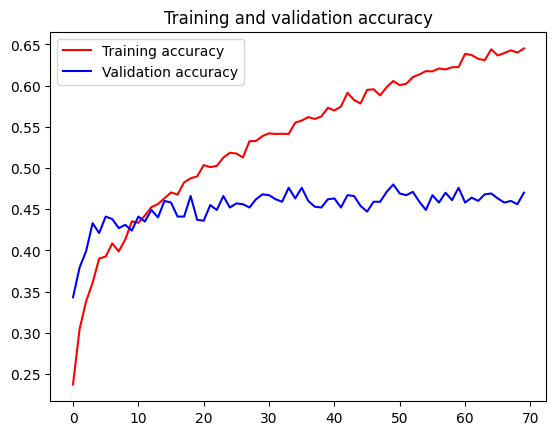

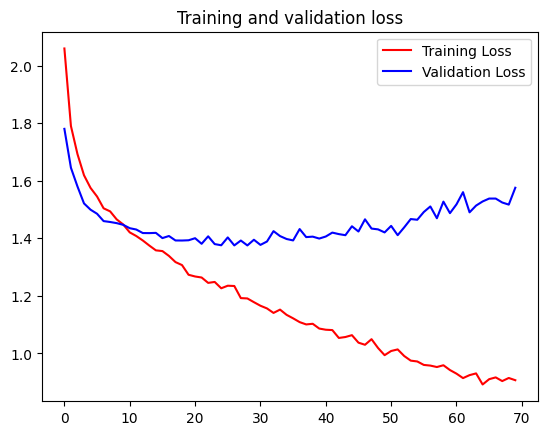

In [12]:
# Plotting the chart for accuracy and loss on both training and validation for analysis process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()